# Music STEMS Final Project
## Kai Kaneshina and Gabriel Quiroz

In [1]:
import numpy as np
import librosa as lb
from librosa import display
import matplotlib.pyplot as plt
import IPython.display as ipd
import scipy.signal as ss
import scipy.io as sio
import glob
import subprocess
import os.path
import operator
import pickle

## Database Constructor

In [2]:
def constructDatabase(indir):
    """
    Construct a database of fingerprints for all mp3 files in the specified directory.
    
    Arguments:
    indir -- directory containing mp3 files
    
    Returns:
    d -- database of artist names, where the key is the artist name
        and the value is the audio array extracted with librosa.
    """
    d = {}

    ### START CODE BLOCK ###
    path = indir + '/*.m4a'
    for filename in glob.iglob(path, recursive=True):  
        audio, sr = lb.core.load(filename, 22050)
        filename = filename.lstrip(indir + '/') #removes the directory from the filename
        name = filename.split(' ')[0] #keeps only the name of the artist
        d[name] = audio
            
    ### END CODE BLOCK ###
    
    return d

In [3]:
db_Scales = constructDatabase('scales') # note that this may take a minute or so to run

In [4]:
with open('db_Scales.pkl','wb') as scales:
    pickle.dump(db_Scales, scales)

In [5]:
with open('db_Scales.pkl','rb') as scales:
    db_Scales = pickle.load(scales)

In [6]:
db_JingleBells = constructDatabase('song') # note that this may take a minute or so to run

In [7]:
with open('db_JingleBells.pkl','wb') as JingleBells:
    pickle.dump(db_JingleBells, JingleBells)

In [8]:
with open('db_JingleBells.pkl','rb') as JingleBells:
    db_JingleBells = pickle.load(JingleBells)

## Functions for Visualization 

In [9]:
def visualizeTemplate(W):
    '''This function allows us the visualize the template matrix (W)'''
    fs = 22050
    winsz = 2048
    
    maxFreq = W.shape[0]*fs/winsz
    maxMidi = W.shape[1]
    
    plt.figure(figsize=(16,5))
    plt.imshow(W, cmap='jet', origin = 'lower', aspect='auto', extent=(0, maxMidi, 0, maxFreq))
    plt.xlabel('Note')
    plt.ylabel('Frequency [Hz]')
    plt.title('Template Matrix Visualization')
    plt.colorbar()
    plt.show()

In [10]:
def visualizeActivations(H):
    '''This function allows us the visualize the activations matrix (H)'''
    fs = 22050
    winsz = 2048
    
    maxNote = H.shape[0]
    maxFrame = H.shape[1]
    
    plt.figure(figsize=(16,5))
    plt.imshow(H, cmap='jet', origin = 'lower', aspect='auto', extent=(0, maxFrame, 0, maxNote))
    plt.xlabel('Frames')
    plt.ylabel('Note')
    plt.title('Activation Matrix Visualization')
    plt.colorbar()
    plt.show()

In [11]:
def visualizeSTFT(STFT):
    '''This function allows us to visualize the log spectrogram of the STFT'''
    fs = 22050
    winsz = 2048
    
    maxFreq = STFT.shape[0]*fs/winsz
    maxFrame = STFT.shape[1]
    
    plt.figure(figsize=(16,5))
    plt.imshow(np.log(STFT), cmap='jet', vmin=-12, origin = 'lower', aspect='auto', extent=(0, maxFrame, 0, maxFreq))
    plt.xlabel('Frame')
    plt.ylabel('Frequency [Hz]')
    plt.title('STFT Visualization')
    plt.colorbar()
    plt.show()

## NMF

In [12]:
def calcSTFT(audio, sr = 22050, winsz = 2048, hop = 512):
    '''Calculate the STFT of the audio'''
    f, t, Zxx = ss.stft(audio, sr, nperseg=winsz, noverlap=winsz-hop)
    return Zxx

In [13]:
def NMF(W, H, V):
    '''The NMF function runs the algorithm until the NMF algorithm causes a change of less than 1e-6 '''
    
    count = 0
    while(True):
        prevEstimate = np.linalg.norm(V - np.matmul(W,H))
        
        H = (H*np.matmul(W.T, V))/(np.matmul(np.matmul(W.T, W), H))
        W = (W*np.matmul(V, H.T))/(np.matmul(np.matmul(W, H), H.T))
        
        count += 1
        newEstimate = np.linalg.norm(V - np.matmul(W,H))
        
        # Take the difference of the previous and newly computed values 
        # If the number is small, then that means there has been little to no change within the NMF algorithm
        # and thus we can stop running the function
        if np.abs(newEstimate - prevEstimate) <= 1e-6:
            break
    return W, H, count 

## Initializing templates

In [14]:
def initTemplates(STFT, midiArray, deltaF=30, sr=22050, winSize=2048):
    '''Creates the initial template for the W matrix'''
    # Convert the midi array values into a frequency array
    freqArray = 440 * pow(2, (midiArray-69)/12)
    
    # Convert the frequency array into an array of k values. Also convert deltaF into a k value as well.
    kArray = np.round(freqArray*winSize/sr).astype(int)
    deltaK = np.round(deltaF*winSize/sr).astype(int)
    
    # Create W with the same amount of rows as the STFT, and the amount of columns equal to number of notes
    W = np.zeros([STFT.shape[0], len(kArray)])
    
    # Loop through the rows in each column
    for i in range(W.shape[1]):
        for j in range(W.shape[0]):
            
            # If our k value is a multiple of the row, we have hit the note, and/or its harmonic
            if (j%kArray[i]==0):
                
                # Set the W array row equal to the max value
                W[j,i] = 1 #np.random.rand()
                
                # Cases for harmonics are below, first init an array for the k values required to satisfy values
                # around harmonic frequencies
                deltaKRange = np.arange(1, (deltaK+1)*j/kArray[i])
                
                # We add the harmonic value to a range of k values based off of the deltaF entered
                harmonicsPositive = j + deltaKRange
                
                # We then remove any k values that are greater than or equal to the amount of rows  
                harmonicsPositive = np.delete(harmonicsPositive, np.where(harmonicsPositive>=W.shape[0])).astype(int)
                
                # We subtract a range of k values based off of the deltaF entered from the harmonic value
                harmonicsNegative = j - deltaKRange
                
                # We then remove any k values that are less than 0 to avoid the out of bounds error  
                harmonicsNegative = np.delete(harmonicsNegative, np.where(harmonicsNegative<0)).astype(int)
                
                # If an array is non-empty, we set the harmonic value + the deltaK values to be a random number

                if harmonicsPositive.size > 0:
                    # Create as many random numbers as indices selected
                    W[harmonicsPositive, i] = np.ones(harmonicsPositive.size)
                    
                if harmonicsNegative.size > 0:
                    # Create as many random numbers as indices selected
                    W[harmonicsNegative, i] = np.ones(harmonicsNegative.size)
            
    return W        

## Activation Initialization

In [15]:
def initActivationMatrix(STFT, fs=22050, hopsize=512, deltaT=.5):
    '''This function allows us to initialize the H matrix by utilizing the STFT and assuming equal note duration.'''
    
    # Parameters to save for creating the H Matrix.
    numRows, numCols = STFT.shape
    numNotes = 8
    
    # Assume that the notes last an equal amount of time.
    noteDuration = int(numCols/numNotes)
    
    deltaFrames = int(deltaT*fs/hopsize) #converts the deltaT (onset value) into frames
    
    # Create the H Matrix
    H = np.zeros([numNotes, numCols])
    
    # Create a range of values that span from the -onset value to the noteDuration + the onset value
    noteLengthInFrames = np.arange(-deltaFrames, noteDuration + deltaFrames + 1)
    
    # The note initially starts at frame 0.
    actFrame = 0
    for i in range(H.shape[0]):
        
        # Creates an array of frame values that need to be set to ones
        noteTimeActive = actFrame + noteLengthInFrames
        
        # Remove frames that are less than zero and greater than shape of activation matrix
        noteTimeActive = np.delete(noteTimeActive, np.where(noteTimeActive < 0)).astype(int)
        noteTimeActive = np.delete(noteTimeActive, np.where(noteTimeActive >= H.shape[1])).astype(int)
        
        # Set the H matrix with as many ones as needed
        H[i, noteTimeActive] = np.ones(noteTimeActive.size)
        
        # Increase the actFrame by the noteDuration for setting the next note.
        actFrame += noteDuration
    return H

## Score Metric

In [16]:
def accuracyScore(queryStftMag, queryActivation, template):
    
    '''
    This function calculates and returns the score for how accurately a scale matches up with the query.
    '''
    
    vEstimate = np.matmul(template, queryActivation)
    score = np.linalg.norm(queryStftMag - vEstimate)
    
    return score

In [17]:
def accuracyScoreMFCCs(queryStftMag, queryActivation, template, hop = 512, winsz=2048, sr=22050, n_mfcc=20):
    
    '''
    This function calculates and returns the score for how accurately a scale matches up with the query based off
    of their MFCC coefficients.
    '''
    
    vEstimate = np.matmul(template, queryActivation)
    
    # Re-create audio based off of magnitude STFTs. Technically need phase here...
    queryAudio = lb.core.istft(queryStftMag, hop_length = hop, win_length = winsz)
    estimateAudio = lb.core.istft(vEstimate, hop_length = hop, win_length = winsz)

    # Calcuate 20 MFCCs for each frame
    queryMFCCs = lb.feature.mfcc(y=queryAudio, sr=sr, n_mfcc = n_mfcc)
    estimateMFCCs = lb.feature.mfcc(y=estimateAudio, sr=sr, n_mfcc = n_mfcc)
    
    # Calcuate difference between the MFCCs
    scoreMFCCs = np.linalg.norm(queryMFCCs - estimateMFCCs)
    
    return scoreMFCCs

In [18]:
def accuracyScoreMelSpec(songAudio, scaleAudio, sr=22050, n_mels=128, fmax=8000):

    '''
    This function will be used compute the similarity between a scale and song. The function will compute the Mel
    spectrograms for each before performing matrix multiplication, returning the normalized result.
    '''
    
    # Calculate spectrogram for the song and scale, the similarity matrix, and the score
    songArtistMelSpec = lb.feature.melspectrogram(y=songAudio, sr=sr, n_mels=n_mels, fmax=fmax)
    
    scaleArtistMelSpec = lb.feature.melspectrogram(y=scaleAudio, sr=sr, n_mels=n_mels, fmax=fmax)
     
    songArtistDb = lb.power_to_db(songArtistMelSpec, ref=np.max)
    scaleArtistDb = lb.power_to_db(scaleArtistMelSpec, ref=np.max)
    
#     similarityMatrix = np.matmul(scaleArtistMelSpec.T,songArtistMelSpec)
    
    similarityMatrix = np.matmul(scaleArtistDb.T,songArtistDb)
    
    scoreMelSpec = np.linalg.norm(similarityMatrix)

    return scoreMelSpec

## Initiate template and activation matrices for the scales

In [19]:
def getAudioTemplatesNMF(db_Scales, midiNotes):

    '''
    This function initializes a random H matrix and a W matrix for the audio based on the scale of the midi
    notes, as well as the STFT, which are used for the NMF function. The function returns a database with the 
    artist's name as the key and W matrix as the value. 
    '''
    
    # Initialize W 
    dbW = {}
    
    # Loop through dictionary's items
    for artist, audio in db_Scales.items():

        # Calculations required for NMF 
        STFT = calcSTFT(audio)
        magSTFT = np.abs(STFT)
        initW = initTemplates(magSTFT, midiNotes)
        
        # Initialize Activation Matrix
        initH = initActivationMatrix(STFT)
        
        # Run the NMF algorithm
        W, H, count = NMF(initW + 1e-9, initH + 1e-9, magSTFT)

        # Save the H, W, and STFT magnitude values to their respective dictionaries.
        dbW[artist] = W

    return dbW

In [20]:
def calculateSingerStoreAll(db_Queries, db_Templates, db_Scales):
    
    '''
    This function iterates through all the queries, calculates the stft of the query, and then iterates through all
    the artist templates. It then calculates the optimal activation matrix as well as the corresponding score. 
    We store the query artist name with all of the template names and their scores into a dictionary. 
    The function then returns the dictionary.
    '''
    
    # Initialize pairing dictionary
    singerPairings = {}
    
    # Loop through the query dictionary's items
    for artistQuery, audio in db_Queries.items():
        
        print('Query Artist Name: ' , artistQuery)
        
        # Calculate STFT for the query
        STFT = calcSTFT(audio)
        magSTFT = np.abs(STFT)
        artistsAndScores = []
        
        # Iterate through all the templates, 
        for artistTemplate, template in db_Templates.items():
            
            # Extract the scale audio from the scale database
            scaleAudio = db_Scales[artistTemplate]
            
            # Calculate the artist's activation matrix based off the template
            artistActivation = np.matmul(np.linalg.inv(np.matmul(template.T, template)), 
                                     np.matmul(template.T, magSTFT))
            
            score = accuracyScore(magSTFT, artistActivation, template)
            scoreMFCC = accuracyScoreMFCCs(magSTFT, artistActivation, template)
            scoreMelSpec = accuracyScoreMelSpec(audio, scaleAudio)
            
            artistsAndScores.append((artistTemplate, score, scoreMFCC, scoreMelSpec))
            print('Template Name: ', artistTemplate)
            print(' Original Score: ', score, ' MFCC Score: ', scoreMFCC, ' Mel Spec Score: ', scoreMelSpec)
            
        
        artistsAndScores.sort(key=operator.itemgetter(1))
        print('Best Template Match via Original Score: ', artistsAndScores[0][0], ' ', artistsAndScores[0][1])
        
        artistsAndScores.sort(key=operator.itemgetter(2))
        print('Best Template Match via MFCC Score: ', artistsAndScores[0][0], ' ', artistsAndScores[0][2])
        
        artistsAndScores.sort(key=operator.itemgetter(3))
        print('Best Template Match via Mel Spec Score: ', artistsAndScores[0][0], ' ', artistsAndScores[0][3])
        
        singerPairings[artistQuery] = artistsAndScores
            
    return singerPairings

In [21]:
midiNotes = np.array([60, 62, 64, 65, 67, 69, 71, 72]) # This list contains the midi values for notes C4 to C5 aka 60 to 72, skipping sharps

In [22]:
db_Templates = getAudioTemplatesNMF(db_Scales, midiNotes)

In [23]:
singerPairingsTotal = calculateSingerStoreAll(db_JingleBells, db_Templates, db_Scales)

Query Artist Name:  Isabel
Template Name:  Sabrina
 Original Score:  0.14801294139487473  MFCC Score:  520.1921753460005  Mel Spec Score:  247607119.3691664
Template Name:  Cynthia
 Original Score:  0.15301911578732832  MFCC Score:  598.8434901979398  Mel Spec Score:  164415260.41021636
Template Name:  Jane
 Original Score:  0.14270143801386015  MFCC Score:  432.507739639061  Mel Spec Score:  200772172.2393226
Template Name:  Kimi
 Original Score:  0.13807210583251808  MFCC Score:  448.2707393280592  Mel Spec Score:  193854258.5979238
Template Name:  Rachel
 Original Score:  0.1521586787660821  MFCC Score:  496.7483372593105  Mel Spec Score:  148535208.64886636
Template Name:  Maya
 Original Score:  0.17459330266403428  MFCC Score:  580.8092045607219  Mel Spec Score:  202396394.15901515
Template Name:  Lucy
 Original Score:  0.1347336058708178  MFCC Score:  406.757074621028  Mel Spec Score:  184668194.7745026
Template Name:  AaronT
 Original Score:  0.17291736423409323  MFCC Score:  59

Template Name:  Mason
 Original Score:  2.7597125277916303  MFCC Score:  2113.280449578015  Mel Spec Score:  241586894.5276995
Template Name:  Gary
 Original Score:  2.688501860600311  MFCC Score:  2217.781640856968  Mel Spec Score:  149125665.4516491
Template Name:  Djassi
 Original Score:  2.6116878013266795  MFCC Score:  2242.305302716127  Mel Spec Score:  167368893.7602677
Template Name:  Lilly
 Original Score:  1.9588744358230963  MFCC Score:  1374.328450034183  Mel Spec Score:  193356762.10215276
Template Name:  Mario
 Original Score:  2.3452866468375135  MFCC Score:  1986.3168898976535  Mel Spec Score:  191440077.21012685
Template Name:  Abtin
 Original Score:  2.7928775362804803  MFCC Score:  1767.9724713054043  Mel Spec Score:  232227576.5193177
Template Name:  Gabe
 Original Score:  2.6573743578096756  MFCC Score:  2018.6369294345504  Mel Spec Score:  185923966.7990345
Template Name:  Kai
 Original Score:  2.6612782637821715  MFCC Score:  1797.9460281988236  Mel Spec Score:  

Template Name:  Sabrina
 Original Score:  0.12976392828795383  MFCC Score:  550.6196397982849  Mel Spec Score:  222928702.11787617
Template Name:  Cynthia
 Original Score:  0.1306213981619015  MFCC Score:  621.2179202897232  Mel Spec Score:  148375796.50815836
Template Name:  Jane
 Original Score:  0.13375498796402563  MFCC Score:  581.1713792231119  Mel Spec Score:  181247675.47555655
Template Name:  Kimi
 Original Score:  0.12169442566658276  MFCC Score:  486.67577212189616  Mel Spec Score:  174629225.28477305
Template Name:  Rachel
 Original Score:  0.131299266156877  MFCC Score:  567.66109878521  Mel Spec Score:  133145104.87529412
Template Name:  Maya
 Original Score:  0.1391117714787581  MFCC Score:  578.4346422219912  Mel Spec Score:  183356196.72613773
Template Name:  Lucy
 Original Score:  0.13510815529009604  MFCC Score:  618.6119069208592  Mel Spec Score:  166153585.03841466
Template Name:  AaronT
 Original Score:  0.13985297211962872  MFCC Score:  631.0805835969471  Mel Spe

Template Name:  Mason
 Original Score:  0.9856189755397116  MFCC Score:  1508.9238201210333  Mel Spec Score:  217941673.4117503
Template Name:  Gary
 Original Score:  0.9552079242581897  MFCC Score:  1551.277857091225  Mel Spec Score:  134637095.78511065
Template Name:  Djassi
 Original Score:  0.9280099813431528  MFCC Score:  1540.7740794009314  Mel Spec Score:  151057540.9501358
Template Name:  Lilly
 Original Score:  0.5707193428828102  MFCC Score:  862.2080390917798  Mel Spec Score:  174597648.77909154
Template Name:  Mario
 Original Score:  0.8196730284087631  MFCC Score:  1398.4123432871193  Mel Spec Score:  172923771.3975963
Template Name:  Abtin
 Original Score:  1.015696311451945  MFCC Score:  1256.7672956930055  Mel Spec Score:  209494232.25191674
Template Name:  Gabe
 Original Score:  0.9057493952237483  MFCC Score:  1509.927437650472  Mel Spec Score:  167949364.8286405
Template Name:  Kai
 Original Score:  1.0002026456361117  MFCC Score:  1451.1377173603441  Mel Spec Score:

Template Name:  Sabrina
 Original Score:  0.33013404110137434  MFCC Score:  691.2615890522686  Mel Spec Score:  225336862.0171712
Template Name:  Cynthia
 Original Score:  0.28670737084279646  MFCC Score:  689.1166162083622  Mel Spec Score:  149071141.2145215
Template Name:  Jane
 Original Score:  0.28717857534513946  MFCC Score:  675.2526567134554  Mel Spec Score:  182095622.23756665
Template Name:  Kimi
 Original Score:  0.30844492991674477  MFCC Score:  648.0617214552726  Mel Spec Score:  176671623.93380117
Template Name:  Rachel
 Original Score:  0.27467466580714306  MFCC Score:  611.2611309193313  Mel Spec Score:  135695418.40629143
Template Name:  Maya
 Original Score:  0.35097498730399984  MFCC Score:  721.9286027770347  Mel Spec Score:  183066180.0613845
Template Name:  Lucy
 Original Score:  0.2695659031334566  MFCC Score:  597.0065107888275  Mel Spec Score:  168587707.53997687
Template Name:  AaronT
 Original Score:  0.379735535236934  MFCC Score:  818.6827031479102  Mel Spec

Template Name:  Mason
 Original Score:  0.13236570067633224  MFCC Score:  562.0667493447537  Mel Spec Score:  309396548.0193079
Template Name:  Gary
 Original Score:  0.13103596347743415  MFCC Score:  586.2122839515032  Mel Spec Score:  191073497.86863175
Template Name:  Djassi
 Original Score:  0.12754379046915987  MFCC Score:  580.6492462769974  Mel Spec Score:  214975072.0854311
Template Name:  Lilly
 Original Score:  0.09393969997822503  MFCC Score:  344.3174710072733  Mel Spec Score:  247568392.71349835
Template Name:  Mario
 Original Score:  0.11241767658122064  MFCC Score:  583.9718189878423  Mel Spec Score:  246227083.93485868
Template Name:  Abtin
 Original Score:  0.13823101690927514  MFCC Score:  549.1739366999942  Mel Spec Score:  298262872.11407125
Template Name:  Gabe
 Original Score:  0.11699072803316245  MFCC Score:  548.5217684468772  Mel Spec Score:  238871990.13548303
Template Name:  Kai
 Original Score:  0.13386103063077412  MFCC Score:  539.8165226525967  Mel Spec 

Template Name:  Sabrina
 Original Score:  0.20365049681902325  MFCC Score:  630.6364096799269  Mel Spec Score:  231407750.22543496
Template Name:  Cynthia
 Original Score:  0.19362492406326287  MFCC Score:  651.9499609736763  Mel Spec Score:  154387544.9467633
Template Name:  Jane
 Original Score:  0.20734388739138268  MFCC Score:  616.8893876738612  Mel Spec Score:  187775691.2479449
Template Name:  Kimi
 Original Score:  0.216346138955  MFCC Score:  627.423251680227  Mel Spec Score:  181876286.52262747
Template Name:  Rachel
 Original Score:  0.20716101715666324  MFCC Score:  601.5496124292388  Mel Spec Score:  138706652.98163217
Template Name:  Maya
 Original Score:  0.21256211201607506  MFCC Score:  578.5667067699184  Mel Spec Score:  191099507.04175732
Template Name:  Lucy
 Original Score:  0.19916448948940157  MFCC Score:  597.7735795940262  Mel Spec Score:  172850406.65569144
Template Name:  AaronT
 Original Score:  0.23485415169777643  MFCC Score:  725.4165257393827  Mel Spec S

Template Name:  Gary
 Original Score:  1.5501248035099056  MFCC Score:  1135.0329825293122  Mel Spec Score:  145903466.0975485
Template Name:  Djassi
 Original Score:  1.6965444803469358  MFCC Score:  1232.079962735256  Mel Spec Score:  164501892.36676374
Template Name:  Lilly
 Original Score:  2.0454407891101143  MFCC Score:  1969.2428316854432  Mel Spec Score:  187836636.74628514
Template Name:  Mario
 Original Score:  1.8625455784003666  MFCC Score:  1741.0922510058901  Mel Spec Score:  187655281.66820115
Template Name:  Abtin
 Original Score:  1.8243815157042271  MFCC Score:  1319.569297030225  Mel Spec Score:  226804995.96716878
Template Name:  Gabe
 Original Score:  1.6189789999460351  MFCC Score:  1245.397058196358  Mel Spec Score:  181668502.3269633
Template Name:  Kai
 Original Score:  1.8673324050588735  MFCC Score:  1610.2999479125356  Mel Spec Score:  187330109.81741616
Template Name:  Chris
 Original Score:  1.8842265106604634  MFCC Score:  1492.3455984739646  Mel Spec Sco

Template Name:  Cynthia
 Original Score:  0.21791621824364307  MFCC Score:  979.217448113103  Mel Spec Score:  145919142.18498713
Template Name:  Jane
 Original Score:  0.21330978637930256  MFCC Score:  888.7155187213777  Mel Spec Score:  178649136.2690531
Template Name:  Kimi
 Original Score:  0.20893793122406182  MFCC Score:  809.8740008796483  Mel Spec Score:  172335219.76138878
Template Name:  Rachel
 Original Score:  0.2143362718573231  MFCC Score:  943.3698158931168  Mel Spec Score:  131687665.99230884
Template Name:  Maya
 Original Score:  0.22272755698715394  MFCC Score:  925.7705361437892  Mel Spec Score:  180746941.1657178
Template Name:  Lucy
 Original Score:  0.21796620679754364  MFCC Score:  936.9839535536205  Mel Spec Score:  163453984.62583438
Template Name:  AaronT
 Original Score:  0.20843859989174174  MFCC Score:  842.5675199754534  Mel Spec Score:  158303000.57972986
Template Name:  Kaitlyn
 Original Score:  0.21140757567616753  MFCC Score:  933.1571640647738  Mel Sp

Template Name:  Gary
 Original Score:  0.47926006429771584  MFCC Score:  1009.1524562435237  Mel Spec Score:  138934710.1478605
Template Name:  Djassi
 Original Score:  0.46053406484066656  MFCC Score:  1017.7064538954877  Mel Spec Score:  156555720.32944474
Template Name:  Lilly
 Original Score:  0.2784179640183632  MFCC Score:  549.3746376590282  Mel Spec Score:  179552744.65114552
Template Name:  Mario
 Original Score:  0.4066153697849998  MFCC Score:  922.5994962019603  Mel Spec Score:  179197790.27471197
Template Name:  Abtin
 Original Score:  0.5037999811205435  MFCC Score:  908.1699390328946  Mel Spec Score:  216632157.1724377
Template Name:  Gabe
 Original Score:  0.46025152503694716  MFCC Score:  1051.0957088090333  Mel Spec Score:  174047436.80005252
Template Name:  Kai
 Original Score:  0.4943424324110986  MFCC Score:  980.3806547730388  Mel Spec Score:  179197327.20304134
Template Name:  Chris
 Original Score:  0.48832706347511906  MFCC Score:  1021.4057414074053  Mel Spec 

## Accuracy Testing

In [24]:
def accuracyTestAll(singerPairingsTotal, xAmount, scoreType):
    
    '''
    This function is used to test the accuracy of the system by seeing if the matching artist is 
    within the top xAmount scores.
    
    The value of scoreType determines how the list is sorted: 
        a value of 'Original' sorts by the original score
        a value of 'MFCC' sorts by the MFCC score
        a value of 'MelSpec' sorts by the Mel Spec score
    '''
    
    # Set the value for sorting the results
    if scoreType=='Original':
        idx = 1
    if scoreType=='MFCC':
        idx = 2
    if scoreType=='MelSpec':
        idx = 3
       
    # Initialize variables
    amountCorrect = 0
    totalSongs = len(singerPairingsTotal)
    
    # Loop through the singerPairingsTotal database 
    for querySinger, resultsSingersAndScores in singerPairingsTotal.items():
        
        # Sort the values by the second entry of the tuple
        resultsSingersAndScores.sort(key=operator.itemgetter(idx))
        
        # Loop through the resultsSingersAndScores as many times as specified by the user.
        for i in range(xAmount):
            
            singer = resultsSingersAndScores[i][0]
            
            if singer == querySinger:
                amountCorrect += 1
                print('score was in the top', xAmount, 'for: ', querySinger)
        
    return amountCorrect/totalSongs

In [25]:
def accuracyTestAllMetrics(singerPairingsTotal, xAmount):
    
    '''
    This function is used to test the accuracy of the system by seeing if the matching artist is 
    within the top xAmount MFCC scores or the original scores or the Mel Spec scores. 
    '''
    
    # Initialize variables
    amountCorrect = 0
    totalSongs = len(singerPairingsTotal)
    
    # Loop through the singerPairingsTotal database 
    for querySinger, resultsSingersAndScores in singerPairingsTotal.items():
        
        # Sort the values by the second entry of the tuple
        
        # Loop through the resultsSingersAndScores as many times as specified by the user.
        for i in range(xAmount):
            resultsSingersAndScores.sort(key=operator.itemgetter(1))
            
            singer = resultsSingersAndScores[i][0]

            resultsSingersAndScores.sort(key=operator.itemgetter(2))

            singerMFCC = resultsSingersAndScores[i][0]
            
            resultsSingersAndScores.sort(key=operator.itemgetter(3))

            singerMelSpec = resultsSingersAndScores[i][0]

            if singer == querySinger or singerMFCC==querySinger or singerMelSpec==querySinger:
                amountCorrect += 1
                print('score was a one to one match for: ', querySinger)
                break 
            
    return amountCorrect/totalSongs

In [26]:
accuracyTop1 = accuracyTestAll(singerPairingsTotal,1,scoreType='Original')

score was in the top 1 for:  Kailee
score was in the top 1 for:  Mario
score was in the top 1 for:  Kaitlyn
score was in the top 1 for:  Gary
score was in the top 1 for:  Djassi
score was in the top 1 for:  Chris


In [27]:
print(accuracyTop1)

0.25


In [28]:
accuracyTop1MFCCs = accuracyTestAll(singerPairingsTotal,1,scoreType='MFCC')

score was in the top 1 for:  Kailee
score was in the top 1 for:  Kai
score was in the top 1 for:  Kevin
score was in the top 1 for:  Lucy
score was in the top 1 for:  Gary
score was in the top 1 for:  Mason
score was in the top 1 for:  AaronT
score was in the top 1 for:  Chris
score was in the top 1 for:  Gabe


In [29]:
print(accuracyTop1MFCCs)

0.375


In [30]:
accuracyTop1MelSpec = accuracyTestAll(singerPairingsTotal,1,scoreType='MelSpec')

score was in the top 1 for:  Rachel


In [31]:
print(accuracyTop1MelSpec)

0.041666666666666664


In [32]:
allThreeMetricsAccuracy = accuracyTestAllMetrics(singerPairingsTotal, 1)

score was a one to one match for:  Kailee
score was a one to one match for:  Kai
score was a one to one match for:  Mario
score was a one to one match for:  Kaitlyn
score was a one to one match for:  Rachel
score was a one to one match for:  Kevin
score was a one to one match for:  Lucy
score was a one to one match for:  Gary
score was a one to one match for:  Mason
score was a one to one match for:  AaronT
score was a one to one match for:  Djassi
score was a one to one match for:  Chris
score was a one to one match for:  Gabe


In [33]:
print(allThreeMetricsAccuracy)

0.5416666666666666


## Male Only Testing

After further analysis, we realized that the males and female sung the notes we asked them to at different ranges. The males sang at C3-C4, but the females sang at C4 to C5. We analyze the difference below:


In [34]:
db_ScalesMales = constructDatabase('scales_male') # note that this may take a minute or so to run

In [35]:
with open('db_ScalesMales.pkl','wb') as scalesMales:
    pickle.dump(db_ScalesMales, scalesMales)

In [36]:
with open('db_ScalesMales.pkl','rb') as scalesMales:
    db_ScalesMales = pickle.load(scalesMales)

In [37]:
db_JingleBellsMales = constructDatabase('song_male') # note that this may take a minute or so to run

In [38]:
with open('db_JingleBellsMales.pkl','wb') as JingleBellsMales:
    pickle.dump(db_JingleBellsMales, JingleBellsMales)

In [39]:
with open('db_JingleBellsMales.pkl','rb') as JingleBellsMales:
    db_JingleBellsMales = pickle.load(JingleBellsMales)

In [40]:
midiNotesMales = np.array([48, 50, 52, 53, 55, 57, 59, 60]) # This list contains the midi values for notes C3 to C4 aka 48 to 60, skipping sharps

In [41]:
db_TemplatesMales = getAudioTemplatesNMF(db_ScalesMales, midiNotesMales)

In [42]:
singerPairingsTotalMales = calculateSingerStoreAll(db_JingleBellsMales, db_TemplatesMales, db_ScalesMales)

Query Artist Name:  Kai
Template Name:  AaronT
 Original Score:  0.21014591308181446  MFCC Score:  729.7727735950674  Mel Spec Score:  154374508.18022206
Template Name:  Shiv
 Original Score:  0.2049526153430542  MFCC Score:  721.4475829163256  Mel Spec Score:  146746987.89336696
Template Name:  Kevin
 Original Score:  0.2224021496480129  MFCC Score:  744.0400172715819  Mel Spec Score:  195085252.8830864
Template Name:  Mason
 Original Score:  0.19451845498714534  MFCC Score:  759.9910137360501  Mel Spec Score:  216899007.27301666
Template Name:  Gary
 Original Score:  0.1784210366810998  MFCC Score:  756.4973975657683  Mel Spec Score:  133730467.92771848
Template Name:  Djassi
 Original Score:  0.17162672054291472  MFCC Score:  748.6333116648005  Mel Spec Score:  150737896.69782212
Template Name:  Mario
 Original Score:  0.18557370593832728  MFCC Score:  784.050987593942  Mel Spec Score:  172710619.81507263
Template Name:  Abtin
 Original Score:  0.20457727672760445  MFCC Score:  759.

Template Name:  Kevin
 Original Score:  2.147492553719593  MFCC Score:  1643.1884951124584  Mel Spec Score:  196737655.88854855
Template Name:  Mason
 Original Score:  1.6528181466608474  MFCC Score:  1254.876928753307  Mel Spec Score:  219726292.7093115
Template Name:  Gary
 Original Score:  1.193039614585893  MFCC Score:  1198.192564898895  Mel Spec Score:  136893028.09280536
Template Name:  Djassi
 Original Score:  1.4488466085769842  MFCC Score:  1553.704750384587  Mel Spec Score:  152414830.95168382
Template Name:  Mario
 Original Score:  1.650485171208216  MFCC Score:  1657.5830564675464  Mel Spec Score:  174045646.91648838
Template Name:  Abtin
 Original Score:  1.8169095010871688  MFCC Score:  1414.7771279707767  Mel Spec Score:  211845511.97186133
Template Name:  Gabe
 Original Score:  1.7501991101491816  MFCC Score:  1248.4640773797232  Mel Spec Score:  169556395.07310477
Template Name:  Kai
 Original Score:  1.8976854232491542  MFCC Score:  1393.1439833067595  Mel Spec Score

Template Name:  Gary
 Original Score:  0.3900326614020746  MFCC Score:  979.330421544902  Mel Spec Score:  131135802.11660299
Template Name:  Djassi
 Original Score:  0.4001982814596349  MFCC Score:  972.3613446977521  Mel Spec Score:  147243532.696955
Template Name:  Mario
 Original Score:  0.39335488626830667  MFCC Score:  1002.5119721550172  Mel Spec Score:  168047046.38841024
Template Name:  Abtin
 Original Score:  0.4049078083529375  MFCC Score:  898.3974533504953  Mel Spec Score:  204674004.348372
Template Name:  Gabe
 Original Score:  0.4192630194735966  MFCC Score:  825.1560388734665  Mel Spec Score:  164616307.28045487
Template Name:  Kai
 Original Score:  0.44973663560972565  MFCC Score:  1098.6348926171804  Mel Spec Score:  168099367.11088094
Template Name:  Chris
 Original Score:  0.44715989378705323  MFCC Score:  1078.7354936405432  Mel Spec Score:  164136153.65140522
Best Template Match via Original Score:  Mason   0.3856945345661919
Best Template Match via MFCC Score:  G

In [43]:
accuracyTop1Males = accuracyTestAll(singerPairingsTotalMales,1,scoreType='Original')

score was in the top 1 for:  Mario
score was in the top 1 for:  Gary
score was in the top 1 for:  AaronT
score was in the top 1 for:  Djassi
score was in the top 1 for:  Chris


In [44]:
print(accuracyTop1Males)

0.45454545454545453


In [45]:
accuracyTop1MFCCsMales = accuracyTestAll(singerPairingsTotalMales,1,scoreType='MFCC')

score was in the top 1 for:  Kai
score was in the top 1 for:  Kevin
score was in the top 1 for:  Gary
score was in the top 1 for:  Mason
score was in the top 1 for:  AaronT
score was in the top 1 for:  Chris
score was in the top 1 for:  Gabe


In [46]:
print(accuracyTop1MFCCsMales)

0.6363636363636364


In [47]:
accuracyTop1MelSpecMales = accuracyTestAll(singerPairingsTotalMales,1,scoreType='MelSpec')

score was in the top 1 for:  Gary


In [48]:
print(accuracyTop1MelSpecMales)

0.09090909090909091


In [49]:
allThreeMetricsAccuracyMales = accuracyTestAllMetrics(singerPairingsTotalMales, 1)

score was a one to one match for:  Kai
score was a one to one match for:  Mario
score was a one to one match for:  Kevin
score was a one to one match for:  Gary
score was a one to one match for:  Mason
score was a one to one match for:  AaronT
score was a one to one match for:  Djassi
score was a one to one match for:  Chris
score was a one to one match for:  Gabe


In [50]:
print(allThreeMetricsAccuracyMales)

0.8181818181818182


## Female Only Testing

In [51]:
db_ScalesFemales = constructDatabase('scales_female') # note that this may take a minute or so to run

In [52]:
with open('db_ScalesFemales.pkl','wb') as scalesFemales:
    pickle.dump(db_ScalesFemales, scalesFemales)

In [53]:
with open('db_ScalesFemales.pkl','rb') as scalesFemales:
    db_ScalesFemales = pickle.load(scalesFemales)

In [54]:
db_JingleBellsFemales = constructDatabase('song_female') # note that this may take a minute or so to run

In [55]:
with open('db_JingleBellsFemales.pkl','wb') as JingleBellsFemales:
    pickle.dump(db_JingleBellsFemales, JingleBellsFemales)

In [56]:
with open('db_JingleBellsFemales.pkl','rb') as JingleBellsFemales:
    db_JingleBellsFemales = pickle.load(JingleBellsFemales)

In [57]:
midiNotesFemales = np.array([60, 62, 64, 65, 67, 69, 71, 72]) # This list contains the midi values for notes C4 to C5 aka 60 to 72, skipping sharps

In [58]:
db_TemplatesFemales = getAudioTemplatesNMF(db_ScalesFemales, midiNotesFemales)

In [59]:
singerPairingsTotalFemales = calculateSingerStoreAll(db_JingleBellsFemales, db_TemplatesFemales, db_ScalesFemales)

Query Artist Name:  Isabel
Template Name:  Sabrina
 Original Score:  0.14801294139487473  MFCC Score:  520.1921753460005  Mel Spec Score:  247607119.3691664
Template Name:  Cynthia
 Original Score:  0.15301911578732832  MFCC Score:  598.8434901979398  Mel Spec Score:  164415260.41021636
Template Name:  Jane
 Original Score:  0.14270143801386015  MFCC Score:  432.507739639061  Mel Spec Score:  200772172.2393226
Template Name:  Kimi
 Original Score:  0.13807210583251808  MFCC Score:  448.2707393280592  Mel Spec Score:  193854258.5979238
Template Name:  Rachel
 Original Score:  0.1521586787660821  MFCC Score:  496.7483372593105  Mel Spec Score:  148535208.64886636
Template Name:  Maya
 Original Score:  0.17459330266403428  MFCC Score:  580.8092045607219  Mel Spec Score:  202396394.15901515
Template Name:  Lucy
 Original Score:  0.1347336058708178  MFCC Score:  406.757074621028  Mel Spec Score:  184668194.7745026
Template Name:  Kaitlyn
 Original Score:  0.1446036274199767  MFCC Score:  43

Template Name:  Lucy
 Original Score:  0.6503613119606512  MFCC Score:  828.7917547250554  Mel Spec Score:  161296275.1537071
Template Name:  Kaitlyn
 Original Score:  0.538545513162292  MFCC Score:  795.0039602597952  Mel Spec Score:  176856013.34499237
Template Name:  Isabel
 Original Score:  0.9444877671355557  MFCC Score:  1132.4282537038405  Mel Spec Score:  162049976.095681
Template Name:  Maria
 Original Score:  0.8944884791346295  MFCC Score:  881.8558962015867  Mel Spec Score:  187819425.47556213
Template Name:  Lilly
 Original Score:  0.5707193428828102  MFCC Score:  862.2080390917798  Mel Spec Score:  174597648.77909154
Template Name:  Annalise
 Original Score:  0.6404036215026845  MFCC Score:  844.5533530780126  Mel Spec Score:  156316358.60799658
Template Name:  Kailee
 Original Score:  0.6581815674334633  MFCC Score:  866.6544090722731  Mel Spec Score:  178680254.71388885
Best Template Match via Original Score:  Kaitlyn   0.538545513162292
Best Template Match via MFCC Sco

Template Name:  Annalise
 Original Score:  0.0867200090514527  MFCC Score:  388.19898569238984  Mel Spec Score:  222933473.6345667
Template Name:  Kailee
 Original Score:  0.08923038667334698  MFCC Score:  440.00858702723156  Mel Spec Score:  253437932.44127652
Best Template Match via Original Score:  Kaitlyn   0.0791341685254889
Best Template Match via MFCC Score:  Kaitlyn   341.90426026822973
Best Template Match via Mel Spec Score:  Rachel   185323608.27864808
Query Artist Name:  Lucy
Template Name:  Sabrina
 Original Score:  0.4356066814697393  MFCC Score:  826.9014823961943  Mel Spec Score:  229501021.62629175
Template Name:  Cynthia
 Original Score:  0.3783712430447  MFCC Score:  781.2242583604793  Mel Spec Score:  151904358.07357636
Template Name:  Jane
 Original Score:  0.41755115320207054  MFCC Score:  754.1395692211656  Mel Spec Score:  185273432.0958215
Template Name:  Kimi
 Original Score:  0.37551519666691424  MFCC Score:  759.0064329149291  Mel Spec Score:  179641694.05389

In [60]:
accuracyTop1Females = accuracyTestAll(singerPairingsTotalFemales,1,scoreType='Original')

score was in the top 1 for:  Kailee
score was in the top 1 for:  Kaitlyn


In [61]:
print(accuracyTop1Females)

0.15384615384615385


In [62]:
accuracyTop1MFCCsFemales = accuracyTestAll(singerPairingsTotalFemales,1,scoreType='MFCC')

score was in the top 1 for:  Kailee
score was in the top 1 for:  Lucy


In [63]:
print(accuracyTop1MFCCsFemales)

0.15384615384615385


In [64]:
accuracyTop1MelSpecFemales = accuracyTestAll(singerPairingsTotalFemales,1,scoreType='MelSpec')

score was in the top 1 for:  Rachel


In [65]:
print(accuracyTop1MelSpecFemales)

0.07692307692307693


In [66]:
allThreeMetricsAccuracyFemales = accuracyTestAllMetrics(singerPairingsTotalFemales, 1)

score was a one to one match for:  Kailee
score was a one to one match for:  Kaitlyn
score was a one to one match for:  Rachel
score was a one to one match for:  Lucy


In [67]:
print(allThreeMetricsAccuracyFemales)

0.3076923076923077


## Analysis

### Annotation for note timings in scale

In [68]:
db_NoteTimings  = {}
db_NoteTimings['Kevin'] = [(0.36, 1.31), (1.60, 2.50), (2.83, 3.78), (4.08, 4.61),
                           (5.30, 6.14), (6.48, 7.22), (7.62, 8.48), (8.93, 10.40)]
db_NoteTimings['Jane'] = [(0.16, 0.94), (1.34, 1.78), (2.21, 2.71), (3.07, 3.66),
                          (3.88, 4.43), (4.91, 5.57), (5.83, 6.48), (6.68, 7.42)]
db_NoteTimings['Lucy'] = [(0.20, 0.77), (0.93, 1.54), (1.82, 2.41), (2.70, 3.22),
                         (3.49, 4.11), (4.30, 5.04), (5.25, 5.89), (6.14, 6.62)]
db_NoteTimings['Maya'] = [(0.28, 0.95), (1.16, 1.81), (1.94, 2.59), (2.76, 3.38),
                         (3.61, 4.18), (4.35, 5.04), (5.24, 5.86), (6.02, 6.49)]
db_NoteTimings['Shiv'] = [(0.16, 0.69), (0.82, 1.47), (1.62, 2.19), (2.27, 2.83),
                         (3.07, 3.73), (3.80, 4.39), (4.66, 5.18), (5.44, 6.11)]
db_NoteTimings['Djassi'] = [(0.17, 0.78), (0.98, 1.60), (1.73, 2.35), (2.52, 3.15),
                           (3.30, 3.90), (4.05, 4.42), (4.90, 5.52), (5.68, 6.31)]
db_NoteTimings['Isabel'] = [(0.21, 0.73), (0.88, 1.32), (1.59, 2.08), (2.32, 2.77),
                            (2.95, 3.42), (3.57, 4.01), (4.20, 4.65), (4.90, 5.25)]
db_NoteTimings['Kai'] = [(0.23, 0.86), (1.17, 1.85), (2.15, 2.80), (3.17, 3.76),
                        (4.11, 4.79), (5.11, 5.42), (6.01, 6.74), (6.93, 7.46)]

In [69]:
db_NoteTimings['Jane']

[(0.16, 0.94),
 (1.34, 1.78),
 (2.21, 2.71),
 (3.07, 3.66),
 (3.88, 4.43),
 (4.91, 5.57),
 (5.83, 6.48),
 (6.68, 7.42)]

In [70]:
def calculateMelSpecTemplate(artist, noteTimings, scaleDataBase=db_Scales, sr=22050):
    melSpecTemplate = np.zeros([128, 8])
    scaleAudio = scaleDataBase[artist]
    for i in range(len(noteTimings)):
        startTime, endTime = noteTimings[i]
        startIdx = int(np.ceil(startTime*sr))
        endIdx = int(endTime*sr)
        window = scaleAudio[startIdx:endIdx]
        noteMelSpec = lb.feature.melspectrogram(y=window, sr=sr, n_mels=128, fmax=8000)
        noteMelSpecVector = np.sum(noteMelSpec, axis=1)
        noteMelSpecNorm = noteMelSpecVector/np.linalg.norm(noteMelSpecVector)
        melSpecTemplate[:, i] = noteMelSpecNorm
    return melSpecTemplate

In [71]:
kevinScaleMelSpec = calculateMelSpecTemplate('Kevin', db_NoteTimings['Kevin'])
janeScaleMelSpec = calculateMelSpecTemplate('Jane', db_NoteTimings['Jane'])
lucyScaleMelSpec = calculateMelSpecTemplate('Lucy', db_NoteTimings['Lucy'])
mayaScaleMelSpec = calculateMelSpecTemplate('Maya', db_NoteTimings['Maya'])
shivScaleMelSpec = calculateMelSpecTemplate('Shiv', db_NoteTimings['Shiv'])
djassiScaleMelSpec = calculateMelSpecTemplate('Djassi', db_NoteTimings['Djassi'])
isabelScaleMelSpec = calculateMelSpecTemplate('Isabel', db_NoteTimings['Isabel'])
kaiScaleMelSpec = calculateMelSpecTemplate('Kai', db_NoteTimings['Kai'])

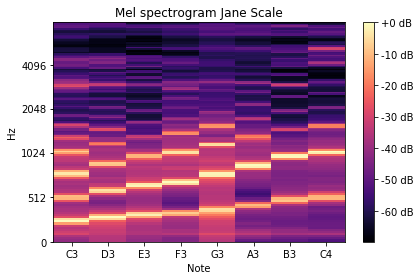

In [72]:
lb.display.specshow(lb.power_to_db(janeScaleMelSpec, ref=np.max), y_axis='mel', fmax=8000)
plt.xlabel('Note')
plt.xticks(np.arange(0, 8)+.5, ('C3', 'D3', 'E3', 'F3', 'G3', 'A3', 'B3', 'C4'))
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram Jane Scale')
plt.tight_layout()

In [73]:
kevinJingleMelSpec = lb.feature.melspectrogram(db_JingleBells['Kevin'], sr=22050, n_mels=128, fmax=8000)
janeJingleMelSpec = lb.feature.melspectrogram(db_JingleBells['Jane'], sr=22050, n_mels=128, fmax=8000)
lucyJingleMelSpec = lb.feature.melspectrogram(db_JingleBells['Lucy'], sr=22050, n_mels=128, fmax=8000)
mayaJingleMelSpec = lb.feature.melspectrogram(db_JingleBells['Maya'], sr=22050, n_mels=128, fmax=8000)
shivJingleMelSpec = lb.feature.melspectrogram(db_JingleBells['Shiv'], sr=22050, n_mels=128, fmax=8000)
djassiJingleMelSpec = lb.feature.melspectrogram(db_JingleBells['Djassi'], sr=22050, n_mels=128, fmax=8000)
isabelJingleMelSpec = lb.feature.melspectrogram(db_JingleBells['Isabel'], sr=22050, n_mels=128, fmax=8000)
kaiJingleMelSpec = lb.feature.melspectrogram(db_JingleBells['Kai'], sr=22050, n_mels=128, fmax=8000)

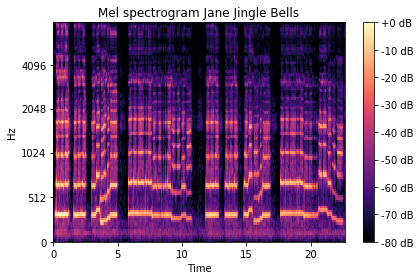

In [74]:
lb.display.specshow(lb.power_to_db(janeJingleMelSpec, ref=np.max), y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram Jane Jingle Bells')
plt.tight_layout()

In [75]:
def calculateMelSpecDotProduct(artist, scaleMelSpec, queryDataBase=db_JingleBells):
    querySong = queryDataBase[artist]
    queryMelSpec = lb.feature.melspectrogram(y=querySong, sr=22050, n_mels=128, fmax=8000)
    print(queryMelSpec.shape)
    melSpecEnergy = np.matmul(scaleMelSpec.T, queryMelSpec)
    return melSpecEnergy

In [76]:
kevinMelSpecEnergy = calculateMelSpecDotProduct('Kevin', kevinScaleMelSpec)
janeMelSpecEnergy = calculateMelSpecDotProduct('Jane', janeScaleMelSpec)
lucyMelSpecEnergy = calculateMelSpecDotProduct('Lucy', lucyScaleMelSpec)
mayaMelSpecEnergy = calculateMelSpecDotProduct('Maya', mayaScaleMelSpec)
shivMelSpecEnergy = calculateMelSpecDotProduct('Shiv', shivScaleMelSpec)
djassiMelSpecEnergy = calculateMelSpecDotProduct('Djassi', djassiScaleMelSpec)
isabelMelSpecEnergy = calculateMelSpecDotProduct('Isabel', isabelScaleMelSpec)
kaiMelSpecEnergy = calculateMelSpecDotProduct('Kai', kaiScaleMelSpec)

janeSongKevinScale = calculateMelSpecDotProduct('Jane', kevinScaleMelSpec)
kevinSongJaneScale = calculateMelSpecDotProduct('Kevin', janeScaleMelSpec)
isabelSongLucyScale = calculateMelSpecDotProduct('Isabel', lucyScaleMelSpec)
kaiSongDjassiScale = calculateMelSpecDotProduct('Kai', djassiScaleMelSpec)

(128, 721)
(128, 975)
(128, 638)
(128, 674)
(128, 602)
(128, 550)
(128, 647)
(128, 622)
(128, 975)
(128, 721)
(128, 647)
(128, 622)


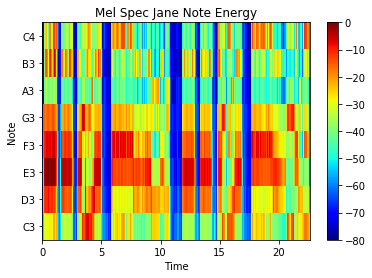

In [77]:
maxTime = janeMelSpecEnergy.shape[1]*512/22050
plt.imshow(lb.power_to_db(janeMelSpecEnergy, ref=np.max), origin = 'lower', aspect='auto', 
           cmap = 'jet', extent=(0, maxTime, 0, 8))
plt.yticks(np.arange(0, 8)+.5, ('C3', 'D3', 'E3', 'F3', 'G3', 'A3', 'B3', 'C4'))
plt.title('Mel Spec Jane Note Energy')
plt.ylabel('Note')
plt.xlabel('Time')
plt.colorbar()
plt.show()

In [78]:
def calcNotePlayedFrame(artistMelSpecEnergy):
    notePlayedFrame = np.zeros(artistMelSpecEnergy.shape)
    print(notePlayedFrame.shape)
    for frame in range(artistMelSpecEnergy.shape[1]):
        maxNote = np.argmax(artistMelSpecEnergy[:, frame])
        notePlayedFrame[maxNote, frame] = 1
    return notePlayedFrame

In [79]:
kevinJingleNotePresent = calcNotePlayedFrame(kevinMelSpecEnergy)
janeJingleNotePresent = calcNotePlayedFrame(janeMelSpecEnergy)
lucyJingleNotePresent = calcNotePlayedFrame(lucyMelSpecEnergy)
mayaJingleNotePresent = calcNotePlayedFrame(mayaMelSpecEnergy)
shivJingleNotePresent = calcNotePlayedFrame(shivMelSpecEnergy)
djassiJingleNotePresent = calcNotePlayedFrame(djassiMelSpecEnergy)
isabelJingleNotePresent = calcNotePlayedFrame(isabelMelSpecEnergy)
kaiJingleNotePresent = calcNotePlayedFrame(kaiMelSpecEnergy)

kevinJingleJaneTemp = calcNotePlayedFrame(kevinSongJaneScale)
janeJingleKevinTemp = calcNotePlayedFrame(janeSongKevinScale)
isabelJingleLucyTemp = calcNotePlayedFrame(isabelSongLucyScale)
kaiJingleDjassiTemp = calcNotePlayedFrame(kaiSongDjassiScale)

(8, 721)
(8, 975)
(8, 638)
(8, 674)
(8, 602)
(8, 550)
(8, 647)
(8, 622)
(8, 721)
(8, 975)
(8, 647)
(8, 622)


In [80]:
def displayNotePlayedInQuery(notePresent):
    maxTime = notePresent.shape[1]*512/22050
    plt.imshow(notePresent, origin = 'lower', aspect='auto', 
               cmap = 'jet', extent=(0, maxTime, 0, 8))
    plt.yticks(np.arange(0, 8)+.5, ('C3', 'D3', 'E3', 'F3', 'G3', 'A3', 'B3', 'C4'))
    plt.ylabel('Note')
    plt.xlabel('Time')
    plt.colorbar()
    plt.show()

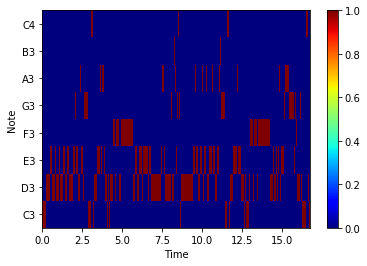

'Kevin Jingle Bells Kevin Template'

In [81]:
displayNotePlayedInQuery(kevinJingleNotePresent)
'''Kevin Jingle Bells Kevin Template'''

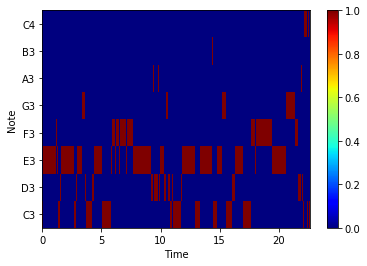

'Jane Jingle Bells Jane Template'

In [82]:
displayNotePlayedInQuery(janeJingleNotePresent)
'''Jane Jingle Bells Jane Template'''

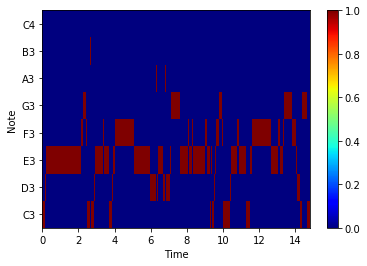

'Lucy Jingle Bells Lucy Template'

In [83]:
displayNotePlayedInQuery(lucyJingleNotePresent)
'''Lucy Jingle Bells Lucy Template'''

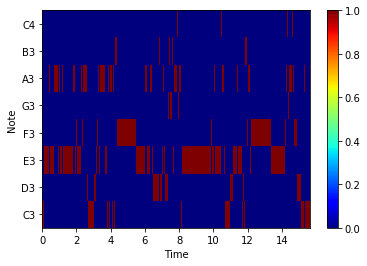

'Maya Jingle Bells Maya Template'

In [84]:
displayNotePlayedInQuery(mayaJingleNotePresent)
'''Maya Jingle Bells Maya Template'''

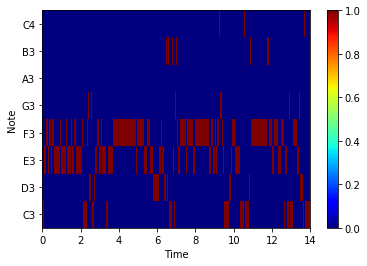

'Shiv Jingle Bells Shiv Template'

In [85]:
displayNotePlayedInQuery(shivJingleNotePresent)
'''Shiv Jingle Bells Shiv Template'''

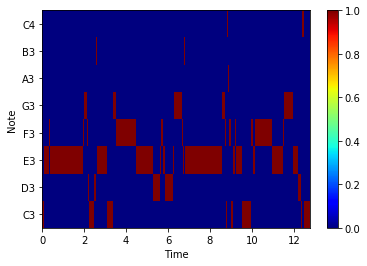

'Djassi Jingle Bells Djassi Template'

In [86]:
displayNotePlayedInQuery(djassiJingleNotePresent)
'''Djassi Jingle Bells Djassi Template'''

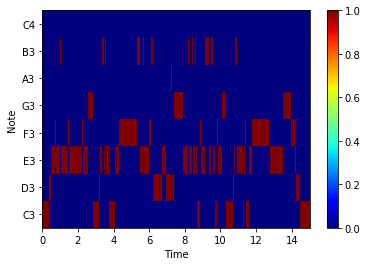

'Isabel Jingle Bells Isabel Template'

In [87]:
displayNotePlayedInQuery(isabelJingleNotePresent)
'''Isabel Jingle Bells Isabel Template'''

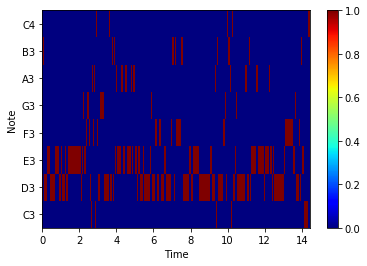

'Kai Jingle Bells Kai Template'

In [88]:
displayNotePlayedInQuery(kaiJingleNotePresent)
'''Kai Jingle Bells Kai Template'''

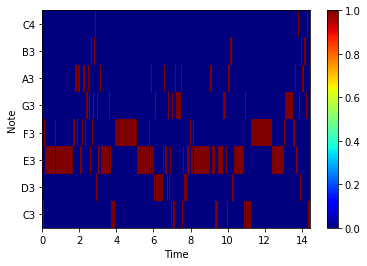

'Kai Jingle Bells Djassi Template'

In [89]:
displayNotePlayedInQuery(kaiJingleDjassiTemp)
'''Kai Jingle Bells Djassi Template'''

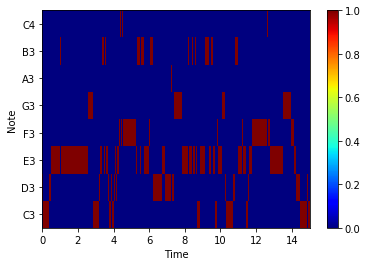

'Isabel Jingle Bells Lucy Template'

In [90]:
displayNotePlayedInQuery(isabelJingleLucyTemp)
'''Isabel Jingle Bells Lucy Template'''

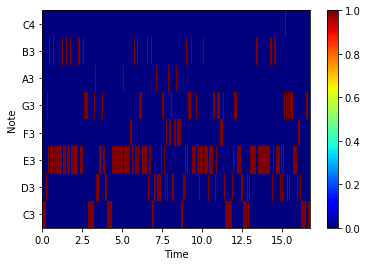

'Kevin Jingle Bells Jane Template'

In [91]:
displayNotePlayedInQuery(kevinJingleJaneTemp)
'''Kevin Jingle Bells Jane Template'''

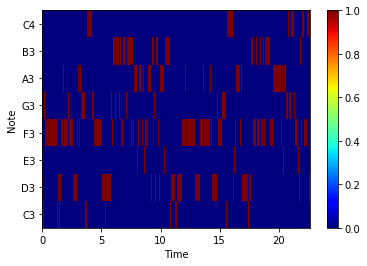

'Jane Jingle Bells Kevin Template'

In [92]:
displayNotePlayedInQuery(janeJingleKevinTemp)
'''Jane Jingle Bells Kevin Template'''

## Analyze Timbre Differences

In [136]:
eeeAudio, sr = lb.core.load('eee.m4a', 22050)

In [137]:
ahhAudio, sr = lb.core.load('ahh.m4a', 22050)

In [138]:
oooAudio, sr = lb.core.load('ooo.m4a', 22050)

In [139]:
def plotDFT(x, sr, title, zoomStart = 0, zoomEnd = sr/16):
    X = np.fft.fft(x)
    f = np.arange(0,sr,sr/len(x))
    maxIdx = np.int(zoomEnd*len(x)/sr*1.0)
    minIdx = np.int(zoomStart*len(x)/sr*1.0)
    plt.figure(figsize=(12,4))
    plt.plot(f[minIdx:maxIdx],np.abs(X[minIdx:maxIdx]))
    plt.title('Magnitude of ' + title)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('DFT Magnitude')


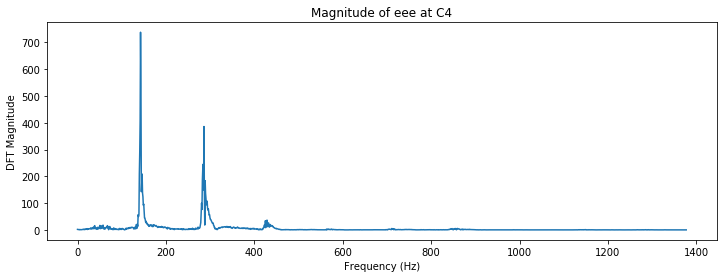

In [140]:
plotDFT(eeeAudio, sr, 'eee at C4')

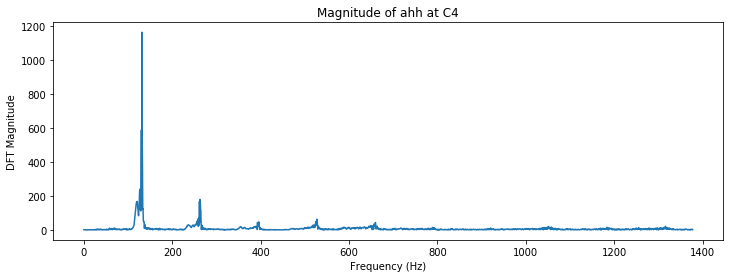

In [141]:
plotDFT(ahhAudio, sr, 'ahh at C4')

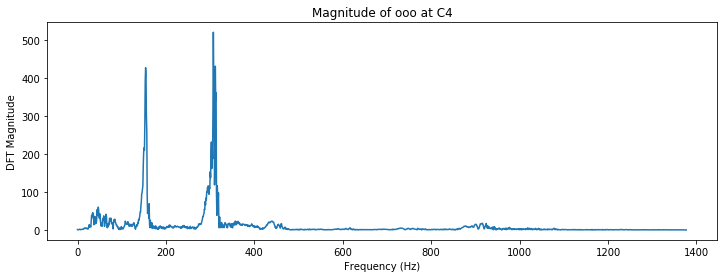

In [142]:
plotDFT(oooAudio, sr, 'ooo at C4')